AIM: To perform intent classification using LSTM (vanilla, stacked, and bidirectional).

In [ ]:
# import libraries
from google.colab import drive
import os

import tensorflow as tf
from tensorflow.keras import layers

import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# mount google drive and connect working directory
drive.mount('/content/gdrive', force_remount = True)
print (sorted(os.listdir('gdrive/My Drive/Colab Helper/ICData/Dataset')))
os.chdir('gdrive/My Drive/Colab Helper/ICData/Dataset') # Connect to the directory

Mounted at /content/gdrive
['data_file.csv', 'glove.6B.100d.txt', 'glove.6B.50d.txt', 'model', 'saved_model', 'test_.csv', 'train_.csv', 'valid_.csv']


In [ ]:
# read train file and print it's shape
traindf = pd.read_csv('train_.csv', usecols=['text','intent'])
testdf = pd.read_csv('test_.csv', usecols=['text','intent'])
validdf = pd.read_csv('valid_.csv', usecols=['text','intent'])

print('Train Shape: ', traindf.shape)
print('Test Shape: ', testdf.shape)
print('Valid Shape: ', validdf.shape)

Train Shape:  (9951, 2)
Test Shape:  (1280, 2)
Valid Shape:  (2985, 2)


Observation:

1.   No NULL value present.

In [ ]:
# NULL value presence check
print('NULL values: ', traindf['text'].isnull().sum())

NULL values:  0


Observation:

1.   Texts may not require a lot of text cleaning.

In [ ]:
# display first 10 rows
print('First 10 rows:\n', traindf.head(10))

First 10 rows:
                                                 text              intent
0                          find under night in-birth  SearchCreativeWork
1         book a spot in town in the same area as me      BookRestaurant
2                                         fimd glory  SearchCreativeWork
3       i need a restaurant on july 18th in rose bud      BookRestaurant
4  book a spot for 4 in oklahoma at south street ...      BookRestaurant
5  i need to know what the weather will be like i...          GetWeather
6  book a bistro in new zealand in 119 and a half...      BookRestaurant
7           need a table for nine in east prairie la      BookRestaurant
8  book a table for mindy and angelita at a resta...      BookRestaurant
9  find me a table for two at seven somewhere in ...      BookRestaurant


**Text Processing**

**Text Standardization, Tokenization, and Vectorization** (using tf.keras.layers.TextVectorization layer)

1.   Convert to lowercase. ✅
2.   Keep alphanumeric (remove punctuations if any). ✅
3.   Remove stopwords. ✅
4.   Perform stemming/lemmatization. ❌

In [ ]:
# function to perform standardization
@tf.keras.utils.register_keras_serializable() # if this line is not present; then the exported model will raise error while performing predictions
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  remove_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')
  remove_stopwords = tf.strings.regex_replace(remove_punctuation, r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*', '')
  return remove_stopwords

In [ ]:
# creating TextVectorization layer
max_features = 10000
sequence_length = 65

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# calling adapt on a text-only dataset (without labels) of training data
raw_train_ds = tf.data.Dataset.from_tensor_slices(traindf['text']).batch(64)
vectorize_layer.adapt(raw_train_ds)

In [ ]:
# get vocabulary size
voc = vectorize_layer.get_vocabulary()
print('Vocabulary size: {}'.format(len(voc)))

Vocabulary size: 9438


**Process Inputs**

In [ ]:
# label encode
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(traindf['intent']) # fit label encoder
print('Label Encoder Classes: ', label_encoder.classes_)

# transform labels
traindf['intent'] = label_encoder.transform(traindf['intent'])
testdf['intent'] = label_encoder.transform(testdf['intent'])
validdf['intent'] = label_encoder.transform(validdf['intent'])

Label Encoder Classes:  ['AddToPlaylist' 'BookRestaurant' 'GetWeather' 'PlayMusic' 'RateBook'
 'SearchCreativeWork' 'SearchScreeningEvent']


In [ ]:
# convert model input data to arrays
x_train = np.array([np.array(val) for val in traindf['text']])
x_val = np.array([np.array(val) for val in validdf['text']])

y_train = np.array([np.array(val) for val in traindf['intent']])
y_val = np.array([np.array(val) for val in validdf['intent']])

**MLP Training**

Model 1

In [ ]:
# model definition
num_tokens = len(voc) + 2
embedding_dim = 8

model1 = tf.keras.Sequential([
  vectorize_layer,
  layers.Embedding(num_tokens, embedding_dim, mask_zero=True, name='Embedding_1'), # mask_zero set to True
  layers.LSTM(12, name='LSTM_1'),
  layers.Dense(8, activation='relu', name='Dense_1'),
  layers.Dropout(0.2, name='Dropout_1'),
  layers.Dense(7, activation='softmax', name='Dense_2')])

model1._name = 'Modelwith1LSTMLayer'
model1.summary()

Model: "Modelwith1LSTMLayer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 65)               0         
 torization)                                                     
                                                                 
 Embedding_1 (Embedding)     (None, 65, 8)             75520     
                                                                 
 LSTM_1 (LSTM)               (None, 12)                1008      
                                                                 
 Dense_1 (Dense)             (None, 8)                 104       
                                                                 
 Dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 Dense_2 (Dense)             (None, 7)                 63        
                                               

In [ ]:
# model compiling
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

# model training
epochs = 20
%time history = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)

Epoch 1/20
311/311 [==============================] - 24s 48ms/step - loss: 1.3660 - accuracy: 0.4848 - val_loss: 0.6053 - val_accuracy: 0.9283
Epoch 2/20
311/311 [==============================] - 13s 43ms/step - loss: 0.5141 - accuracy: 0.8397 - val_loss: 0.2186 - val_accuracy: 0.9621
Epoch 3/20
311/311 [==============================] - 13s 43ms/step - loss: 0.3113 - accuracy: 0.9004 - val_loss: 0.1560 - val_accuracy: 0.9685
Epoch 4/20
311/311 [==============================] - 16s 50ms/step - loss: 0.2308 - accuracy: 0.9228 - val_loss: 0.1523 - val_accuracy: 0.9705
Epoch 5/20
311/311 [==============================] - 14s 45ms/step - loss: 0.1991 - accuracy: 0.9308 - val_loss: 0.1519 - val_accuracy: 0.9682
Epoch 6/20
311/311 [==============================] - 15s 47ms/step - loss: 0.1742 - accuracy: 0.9348 - val_loss: 0.1619 - val_accuracy: 0.9662
Epoch 7/20
311/311 [==============================] - 13s 43ms/step - loss: 0.1572 - accuracy: 0.9395 - val_loss: 0.1774 - val_accuracy:

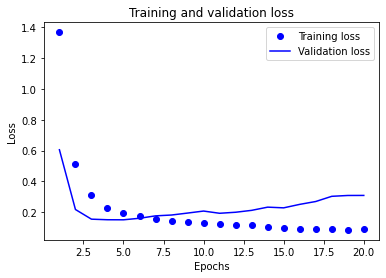

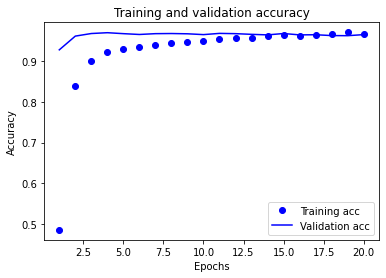

In [ ]:
# plot the graphs
history_dict = history.history # dictionary of result values
epochs = range(1, len(history_dict['accuracy']) + 1) # number of epochs

# plot for loss
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot for accuracy
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Model 2

In [ ]:
# model definition
num_tokens = len(voc) + 2
embedding_dim = 8

model2 = tf.keras.Sequential([
  vectorize_layer,
  layers.Embedding(num_tokens, embedding_dim, mask_zero=True, name='Embedding_1'), # mask_zero set to True
  layers.Bidirectional(tf.keras.layers.LSTM(12), name='Bidirectional_1'),
  layers.Dense(8, activation='relu', name='Dense_1'),
  layers.Dropout(0.2, name='Dropout_1'),
  layers.Dense(7, activation='softmax', name='Dense_2')])

model2._name = 'Modelwith1BidirectionalLayer'
model2.summary()

Model: "Modelwith1BidirectionalLayer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 65)               0         
 torization)                                                     
                                                                 
 Embedding_1 (Embedding)     (None, 65, 8)             75520     
                                                                 
 Bidirectional_1 (Bidirectio  (None, 24)               2016      
 nal)                                                            
                                                                 
 Dense_1 (Dense)             (None, 8)                 200       
                                                                 
 Dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 Dense_2 (Dense)             (None, 7)

In [ ]:
# model compiling
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

# model training
epochs = 20
%time history = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)

Epoch 1/20
311/311 [==============================] - 32s 77ms/step - loss: 1.4919 - accuracy: 0.4047 - val_loss: 0.8255 - val_accuracy: 0.7765
Epoch 2/20
311/311 [==============================] - 20s 66ms/step - loss: 0.6760 - accuracy: 0.7791 - val_loss: 0.3112 - val_accuracy: 0.9524
Epoch 3/20
311/311 [==============================] - 21s 66ms/step - loss: 0.3530 - accuracy: 0.8854 - val_loss: 0.1535 - val_accuracy: 0.9702
Epoch 4/20
311/311 [==============================] - 21s 67ms/step - loss: 0.2702 - accuracy: 0.9049 - val_loss: 0.1335 - val_accuracy: 0.9685
Epoch 5/20
311/311 [==============================] - 21s 66ms/step - loss: 0.2291 - accuracy: 0.9108 - val_loss: 0.1249 - val_accuracy: 0.9672
Epoch 6/20
311/311 [==============================] - 21s 66ms/step - loss: 0.1974 - accuracy: 0.9203 - val_loss: 0.1209 - val_accuracy: 0.9672
Epoch 7/20
311/311 [==============================] - 25s 81ms/step - loss: 0.1832 - accuracy: 0.9234 - val_loss: 0.1207 - val_accuracy:

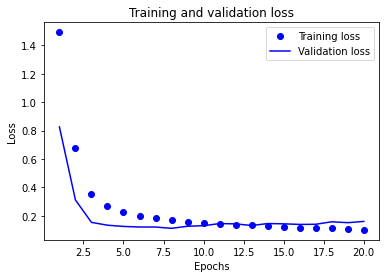

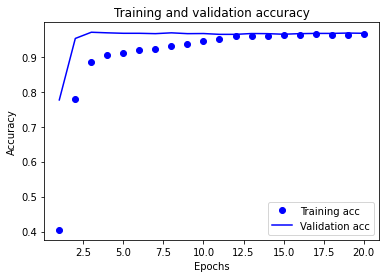

In [ ]:
# plot the graphs
history_dict = history.history # dictionary of result values
epochs = range(1, len(history_dict['accuracy']) + 1) # number of epochs

# plot for loss
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot for accuracy
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# model definition
num_tokens = len(voc) + 2
embedding_dim = 8

model3 = tf.keras.Sequential([
  vectorize_layer,
  layers.Embedding(num_tokens, embedding_dim, mask_zero=True, name='Embedding_1'), # mask_zero set to True
  layers.LSTM(6, return_sequences=True, name='LSTM_1'),
  layers.LSTM(4, name='LSTM_2'),
  layers.Dense(8, activation='relu', name='Dense_1'),
  layers.Dropout(0.2, name='Dropout_1'),
  layers.Dense(7, activation='softmax', name='Dense_2')])

model3._name = 'Modelwith2LSTMLayers'
model3.summary()

Model: "Modelwith2LSTMLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 65)               0         
 torization)                                                     
                                                                 
 Embedding_1 (Embedding)     (None, 65, 8)             75520     
                                                                 
 LSTM_1 (LSTM)               (None, 65, 6)             360       
                                                                 
 LSTM_2 (LSTM)               (None, 4)                 176       
                                                                 
 Dense_1 (Dense)             (None, 8)                 40        
                                                                 
 Dropout_1 (Dropout)         (None, 8)                 0         
                                              

In [ ]:
# model compiling
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

# model training
epochs = 25
%time history = model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)

Epoch 1/25
311/311 [==============================] - 38s 96ms/step - loss: 1.4827 - accuracy: 0.4409 - val_loss: 0.8495 - val_accuracy: 0.7605
Epoch 2/25
311/311 [==============================] - 25s 80ms/step - loss: 0.7100 - accuracy: 0.7872 - val_loss: 0.4238 - val_accuracy: 0.9353
Epoch 3/25
311/311 [==============================] - 27s 87ms/step - loss: 0.4814 - accuracy: 0.8637 - val_loss: 0.2984 - val_accuracy: 0.9504
Epoch 4/25
311/311 [==============================] - 25s 81ms/step - loss: 0.3815 - accuracy: 0.8803 - val_loss: 0.2641 - val_accuracy: 0.9487
Epoch 5/25
311/311 [==============================] - 24s 79ms/step - loss: 0.3332 - accuracy: 0.8941 - val_loss: 0.2458 - val_accuracy: 0.9477
Epoch 6/25
311/311 [==============================] - 24s 78ms/step - loss: 0.3001 - accuracy: 0.9006 - val_loss: 0.2126 - val_accuracy: 0.9558
Epoch 7/25
311/311 [==============================] - 25s 79ms/step - loss: 0.2816 - accuracy: 0.9092 - val_loss: 0.2274 - val_accuracy:

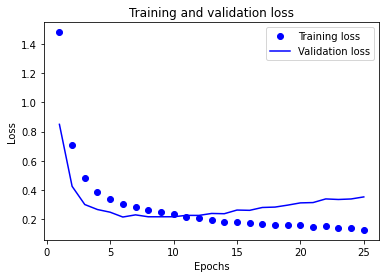

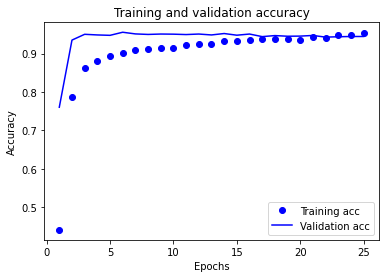

In [ ]:
# plot the graphs
history_dict = history.history # dictionary of result values
epochs = range(1, len(history_dict['accuracy']) + 1) # number of epochs

# plot for loss
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot for accuracy
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

**Evaluate Model**

In [ ]:
# evaluate model on test dataset
x_test = np.array([np.array(val) for val in testdf['text']])
y_test = np.array([np.array(val) for val in testdf['intent']])
# model 1 evaluation
print('Model 1 Evaluation on Test Set:')
loss, accuracy = model1.evaluate(x_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
# model 2 evaluation
print('\nModel 2 Evaluation on Test Set:')
loss, accuracy = model2.evaluate(x_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
# model 3 evaluation
print('\nModel 3 Evaluation on Test Set:')
loss, accuracy = model3.evaluate(x_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Model 1 Evaluation on Test Set:
40/40 [==============================] - 0s 10ms/step - loss: 0.3600 - accuracy: 0.9617
Loss:  0.3599610924720764
Accuracy:  0.961718738079071

Model 2 Evaluation on Test Set:
40/40 [==============================] - 1s 13ms/step - loss: 0.2154 - accuracy: 0.9633
Loss:  0.2153855860233307
Accuracy:  0.9632812738418579

Model 3 Evaluation on Test Set:
40/40 [==============================] - 1s 15ms/step - loss: 0.3423 - accuracy: 0.9500
Loss:  0.34234166145324707
Accuracy:  0.949999988079071


**Export Best Model**

In [ ]:
# save the model
export_model = tf.keras.Sequential([
  tf.keras.Input(shape=(1,), dtype="string"),
  model2 ]) # saving model 2

export_model.save('saved_model/model2_lstm', save_format='tf')

**Conclusion:**

**Model 1:** Vanilla LSTM

INPUT => EMBEDDING(int encoding) => LSTM => FC => RELU => DO => FC => SOFTMAX
1.   Trainable Parameters: 76,695
1.   Epochs: 20
2.   Loss and Accuracy:
    *   Training Loss: 0.0901 - Training Accuracy: 0.9677
    *   Validation Loss: 0.3097 - Validation Accuracy: 0.9658
    *   Testing Loss: 0.3599 - Testing Accuracy: 0.9617
3.   Wall Time: 5min 31s
**Model 2:** BidirectionalLSTM

INPUT => EMBEDDING(int encoding) => BiLSTM => FC => RELU => DO => FC => SOFTMAX
1.   Trainable Parameters: 77,799
1.   Epochs: 20
2.   Loss and Accuracy:
    *   Training Loss: 0.1004 - Training Accuracy: 0.9654
    *   Validation Loss: 0.1602 - Validation Accuracy: 0.9672
    *   Testing Loss: 0.2153 - Testing Accuracy: 0.9632
3.   Wall Time: 7min 29s
**Model 3:** Stacked LSTM

INPUT => EMBEDDING(int encoding) => LSTM => LSTM => FC => RELU => DO => FC => SOFTMAX
1.   Trainable Parameters: 76,159
1.   Epochs: 25
2.   Loss and Accuracy:
    *   Training Loss: 0.1240 - Training Accuracy: 0.9549
    *   Validation Loss: 0.3509 - Validation Accuracy: 0.9447
    *   Testing Loss: 0.3423 - Testing Accuracy: 0.9499
3.   Wall Time: 11min 29s

**ANALYSIS:**
1.   Model 3(stacked LSTM) **with less parameters** can achieve approximately similar or even better performance compared to Model 1(vanilla LSTM), but requires more training epochs to achieve the same.
2.   Model 2(BidirectionalLSTM) achieved better performance compared to other two models.